# In this Notebook, you will find the Module 3 Time Series Decomposition requirements for **Private** Construction Spending

1. Use pandas to import the data and complete your analysis.
2. Use Jupyter for your time series decomposition analysis.
3. Use markdown to document your analysis.
4. For each of the two data series:
   1. Compute the squared error for your model relative to the original data series for each month, and cumulatively as well.
   2. Compute a pandas column named R2X that shows the error of your model relative to the original data series, where X is replaced by either Public or Private for the respective analyses.
   3. Compute a pandas column named R2ErrorX that shows R2 relative to (divided by) the original data series.

In [29]:
##import matplotlib and pandas 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

##read files and drop unnecessary columns
dfTS = pd.read_csv('C:\\Users\\Cora\\Documents\\haleigh\\BUAD 5112\\CTBA\\M3\\ConstructionTimeSeriesDataV2.csv')
dfTS = dfTS.drop('Month', 1)
dfTS = dfTS.drop('Total Construction', 1)
dfTS = dfTS.drop('Public Construction', 1)
print(dfTS)

    Month-Year  Private Construction
0       Jan-02                 45273
1       Feb-02                 44475
2       Mar-02                 49396
3       Apr-02                 53283
4       May-02                 55009
..         ...                   ...
141     Oct-13                 59370
142     Nov-13                 55191
143     Dec-13                 52132
144     Jan-14                 47827
145     Feb-14                 46647

[146 rows x 2 columns]


### Raw Data Plot
The idea of plotting the raw data is to help determine how to best model going forward. With this graph you see the trend of each **cycle** and its nonlinearity and how I can start decomposing them.


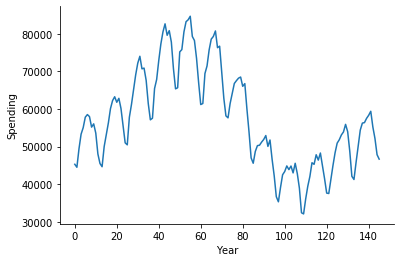

In [30]:
##plot the Private Constructions raw data to understand its linearity 
fig, ax = plt.subplots()
ax.plot(dfTS['Private Construction'], label='Private Construction')
ax.set_xlabel('Year')
ax.set_ylabel('Spending')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

### Square Error and Moving Average
To begin analyzing the trend, I computed the **square error** and **moving average**. Squared Error helped me in picking an appropriate sized window for the moving average. 24 and 36 created a significanly higher Average Squared Error than 12 did. The moving average will help me see trends and offers a smoothed line to help deviate from seeing false spikes or pitfalls.

C:\Users\Cora\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  if __name__ == '__main__':


Average Squared Error per Month:  31701673.583670188
           Month-Year  Private Construction        MovAvg         sqErr
2002-07-31     Jul-02                 58494  52878.250000  3.153665e+07
2002-08-31     Aug-02                 57953  52892.625000  2.560740e+07
2002-09-30     Sep-02                 55157  52923.666667  4.987778e+06
2002-10-31     Oct-02                 56023  52945.000000  9.474084e+06
2002-11-30     Nov-02                 53552  52994.541667  3.107598e+05
...               ...                   ...           ...           ...
2013-04-30     Apr-13                 50022  51844.583333  3.321810e+06
2013-05-31     May-13                 54369  52041.708333  5.416287e+06
2013-06-30     Jun-13                 56228  52235.083333  1.594338e+07
2013-07-31     Jul-13                 56354  52616.291667  1.397046e+07
2013-08-31     Aug-13                 57481  53082.125000  1.935010e+07

[134 rows x 4 columns]


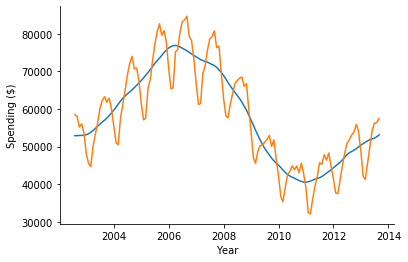

In [31]:
##create square error variable
def sqErr(row):
    return (row['Private Construction'] - row['MovAvg'])**2

dfTS['MovAvg'] = np.NaN
dfTS['sqErr'] = np.NaN

##technical statement creating an index of the data frame to be datetime type
dfTS.index = pd.DatetimeIndex(freq='m', start=pd.Timestamp(year=2002, month=1, day=31), periods = len(dfTS['Private Construction']))

##tried a couple windows, 24 was the most appropriate number
window = 12
window = window - window % 2

for i in range(int(window/2), dfTS.shape[0]-int(window/2)):
    dfTS.loc[dfTS.index[i], 'MovAvg'] = (0.5*dfTS.iloc[i - int(window/2)]['Private Construction'] + dfTS.iloc[i - int(window/2)+1:i + int(window/2)]['Private Construction'].sum() + 0.5 *dfTS.iloc[i + int(window/2)]['Private Construction'])/float(window)
    
##compute squared error
dfTS['sqErr'] = (dfTS['Private Construction'] - dfTS['MovAvg']) **2

##drop rows we cannot use
dfTS.dropna(how='any', inplace=True)

##plot data
fig, ax = plt.subplots()
ax.plot(dfTS['MovAvg'], label='Moving Average')
ax.plot(dfTS['Private Construction'], label = 'Private Construction')
ax.set_xlabel('Year')
ax.set_ylabel('Spending ($)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
print('Average Squared Error per Month: ', sum(dfTS['sqErr'])/len(dfTS))
print(dfTS)

### Residual and Residual Error (R1Private/R1ErrorPrivate)
Next, I computed the first reaminder **residual** for Private Construction spending and each points percentage of spending relative to the moving average. This will determine what is left to explain in my analysis.

In [32]:
##compute remainder and error data, and print
dfTS['R1Private'] = dfTS['Private Construction'] - dfTS['MovAvg']
dfTS['R1ErrorPrivate'] = abs((dfTS['Private Construction'] - dfTS['R1Private'])/dfTS['Private Construction'])
dfTS.style.format({
    'MovAvg': '{:.1f}'.format,
    'sqErr': '{:,.1f}'.format,
    'R1Public': '{:,.1f}'.format,
    'R1ErrorPublic': '{:,.3f}'.format
})

,Month-Year,Private Construction,MovAvg,sqErr,R1Private,R1ErrorPrivate
2002-07-31 00:00:00,Jul-02,58494,52878.2,"31,536,648.1",5615.75,0.903994
2002-08-31 00:00:00,Aug-02,57953,52892.6,"25,607,395.1",5060.38,0.912681
2002-09-30 00:00:00,Sep-02,55157,52923.7,"4,987,777.8",2233.33,0.95951
2002-10-31 00:00:00,Oct-02,56023,52945.0,"9,474,084.0",3078,0.945058
2002-11-30 00:00:00,Nov-02,53552,52994.5,"310,759.8",557.458,0.98959
2002-12-31 00:00:00,Dec-02,48023,53142.5,"26,209,706.9",-5119.54,1.10661
2003-01-31 00:00:00,Jan-03,45473,53392.4,"62,717,160.3",-7919.42,1.17416
2003-02-28 00:00:00,Feb-03,44620,53767.5,"83,677,518.5",-9147.54,1.20501
2003-03-31 00:00:00,Mar-03,49996,54263.0,"18,207,289.0",-4267,1.08535
2003-04-30 00:00:00,Apr-03,53195,54821.3,"2,644,960.1",-1626.33,1.03057


### Plotting R1Private
While plotting the remainder (R1Private), you can see there is still irregularity I have yet to define.  The average is around 30 as the trend line seems to be horizontal at that point.

Average Residual:  30.595149253731616


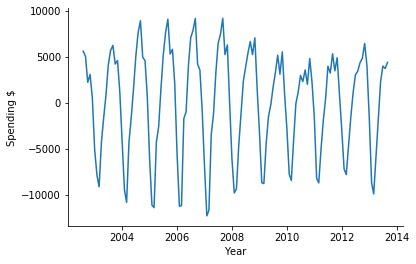

In [35]:
##plot remainder data computed above
fig, ax = plt.subplots()
ax.plot(dfTS['R1Private'])
ax.set_xlabel('Year')
ax.set_ylabel('Spending $')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
print('Average Residual: ', sum(dfTS['R1Private'])/len(dfTS))

### Autocorrelation
To determine whether there are cyclical patterns within periods of time, I computed the correlation. Lag will determine which is the dominant time period. With the maximum correlation being .97, we can conclude there is a strong correlation within the data that repeats itself every 2 years.


In [37]:
##compute autocorrelation relative to each 24 month time period
maxCorr = 0.0
perio = np.NaN
for i in range(1, 13):
    corr = dfTS['R1Private'].autocorr(lag=i)
    print('Correlation, lag ',i,'   ', corr)
    if corr > maxCorr:
        maxCorr = corr
        period = i
print('period = ',period,'    Maximum Correlation = ',maxCorr)

Correlation, lag  1     0.8012201439941178
Correlation, lag  2     0.40461609012732014
Correlation, lag  3     -0.06681918914657627
Correlation, lag  4     -0.4681706539465698
Correlation, lag  5     -0.7334595961596329
Correlation, lag  6     -0.8453947574465045
Correlation, lag  7     -0.7277714550926004
Correlation, lag  8     -0.45905643208796487
Correlation, lag  9     -0.06590030685316589
Correlation, lag  10     0.38876557877044954
Correlation, lag  11     0.7742521355064209
Correlation, lag  12     0.9718794492320818
period =  12     Maximum Correlation =  0.9718794492320818


### Averages for all 12 Points in Cycle
Computing the average cycle within all available cycles in the data helped examine how well the averages fit in the data. with the plot below, you can see the average moves consistently with each of the other cycles

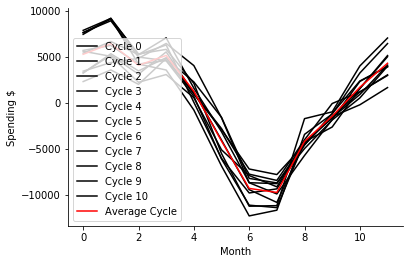

In [38]:
##compute and plot averages and cycle data
period = 12
cycleLen = period
numCycles = int(len(dfTS)/cycleLen + 0.5)
cycles = [dfTS.iloc[range(i*period, min((i+1)*period, len(dfTS)))]['R1Private'] for i in range(numCycles)]
ptsInCycles = [dfTS.iloc[range(i, len(dfTS['R1Private']), period)]['R1Private'].tolist() for i in range(period)]
avg = [sum(pts)/len(pts) for pts in ptsInCycles]

fig, ax = plt.subplots()
for i in range(len(cycles)):
    ax.plot(cycles[i].values, label = 'Cycle '+str(i), c='k')
ax.plot(avg,label = 'Average Cycle', c='r')
ax.set_xlabel('Month')
ax.set_ylabel('Spending $')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()


### Cyclicality
To determine how the averages computed above fared with the remainder values within each cycles data, I computed the cyclicality. This revealed a very good following of (C) to (R1Public).

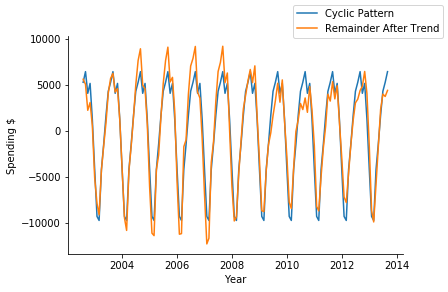

In [39]:
#compute Cyclicality data and plot its consistency with remainder data
cycleLen = period
numCycles = int(len(dfTS)/cycleLen + 0.5)
dfTS['C'] = np.NaN
for i in range(len(dfTS)):
    dfTS.loc[dfTS.index[i], 'C'] = avg[i % cycleLen]
    
fig, ax = plt.subplots()
ax.plot(dfTS['C'], label = 'Cyclic Pattern')
ax.plot(dfTS['R1Private'],label='Remainder After Trend')
ax.set_xlabel('Year')
ax.set_ylabel('Spending $')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()


### Second Remainder (R2Private)
To find the remainder after the 2 components (R1Private & C), I subtracted the two. Also having to find the error of this remainder (R2ErrorPivate), I used a similar equation as R1ErrorPrivate by switching the variable to include this new remainder. Fit being the sum of the moving average and the cyclicality, I used this to plot it against the original data for Private Construction spending.

Average Error:  0.020585783569537188
           Month-Year  Private Construction        MovAvg    R1Private  \
2002-07-31     Jul-02                 58494  52878.250000  5615.750000   
2002-08-31     Aug-02                 57953  52892.625000  5060.375000   
2002-09-30     Sep-02                 55157  52923.666667  2233.333333   
2002-10-31     Oct-02                 56023  52945.000000  3078.000000   
2002-11-30     Nov-02                 53552  52994.541667   557.458333   
...               ...                   ...           ...          ...   
2013-04-30     Apr-13                 50022  51844.583333 -1822.583333   
2013-05-31     May-13                 54369  52041.708333  2327.291667   
2013-06-30     Jun-13                 56228  52235.083333  3992.916667   
2013-07-31     Jul-13                 56354  52616.291667  3737.708333   
2013-08-31     Aug-13                 57481  53082.125000  4398.875000   

            R1ErrorPrivate            C    R2Private  R2ErrorPrivate  \
20

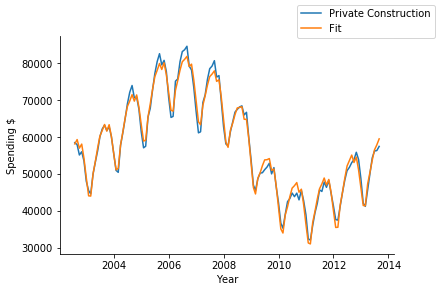

In [40]:
##compute and plot remainder after first remainder (R1) & cyclical data
dfTS['R2Private'] = dfTS['R1Private'] - dfTS['C']
dfTS['R2ErrorPrivate'] = abs(dfTS['R2Private']/dfTS['Private Construction'])
dfTS['fit'] = dfTS['MovAvg'] + dfTS['C']
dfTS.drop(['sqErr'], axis=1, inplace = True)
print('Average Error: ', sum(dfTS['R2ErrorPrivate'])/len(dfTS))
print(dfTS)

fig, ax = plt.subplots()
ax.plot(dfTS['Private Construction'], label = 'Private Construction')
ax.plot(dfTS['fit'], label = 'Fit')
ax.set_xlabel('Year')
ax.set_ylabel('Spending $')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()

Correlation, lag  1     0.6750893529818797
Correlation, lag  2     0.34510105026697396
Correlation, lag  3     -0.04646932554791689
Correlation, lag  4     -0.31441699093452635
Correlation, lag  5     -0.5264754747503062
Correlation, lag  6     -0.5704888079897079
Correlation, lag  7     -0.4674240810825531
Correlation, lag  8     -0.2540684654922095
Correlation, lag  9     -0.05957853056153252
Correlation, lag  10     0.20420845508027607
Correlation, lag  11     0.3982803613194878
Correlation, lag  12     0.5641711274992343
Correlation, lag  13     0.3885919868474461
Correlation, lag  14     0.24867903514059783
Correlation, lag  15     -0.012801082335812505
Correlation, lag  16     -0.17244389682993272
Correlation, lag  17     -0.3198723342230055
Correlation, lag  18     -0.33972891627739227
Correlation, lag  19     -0.24647882498648624
Correlation, lag  20     -0.10355796515376621
Correlation, lag  21     0.009254397800500974
Correlation, lag  22     0.13661370877248727
Correlation, 

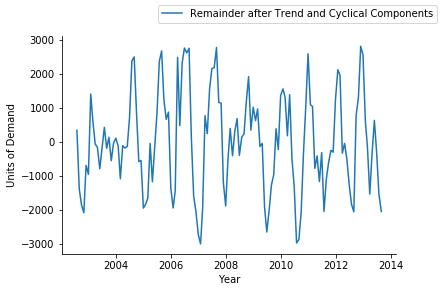

In [42]:
##compute and plot correlation of second remainder and original data
fig, ax = plt.subplots()
ax.plot(dfTS['R2Private'], label = 'Remainder after Trend and Cyclical Components')
ax.set_xlabel('Year')
ax.set_ylabel('Spending ($)')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()
maxCorr = 0.0
period = np.NaN
for i in range(1, 25):
    corr = dfTS['R2Private'].autocorr(lag = i)
    print('Correlation, lag ',i,'   ', corr)
    if corr > maxCorr:
        maxCorr = corr
        period = i
print('period = ',period,'    Maximum Correlation = ',maxCorr)

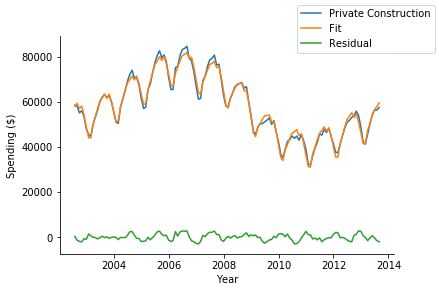

In [44]:
fig, ax = plt.subplots()
ax.plot(dfTS['Private Construction'], label = 'Private Construction')
ax.plot(dfTS['fit'], label = 'Fit')
ax.plot(dfTS['R2Private'], label = 'Residual')
ax.set_xlabel('Year')
ax.set_ylabel('Spending ($)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()